In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

In [53]:
# !wget https://raw.githubusercontent.com/InvalcreInc/parental-control-classification/refs/heads/main/data/toxic_comments.csv

In [54]:
data = pd.read_csv("toxic_comments.csv")
data.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
126310,a3895c8e9e01f436,"""\n""""Borughton""""? Do you mean Ramsay and Vaugh...",0,0,0,0,0,0
50906,881fbf355aa43b3c,I may assure you that I am sober by now. Someh...,1,0,0,0,0,0
81366,d9a153c0d53ee949,"""\n\nI'll try:\n\n Talk | \n\nI hope it is of ...",0,0,0,0,0,0
138405,e479d6d58993c62b,"""\n\n Lindsay Lohan \n\nGreetings! As no doubt...",0,0,0,0,0,0
151298,7abc9f833f0ec939,Your point being? This is my first revert in 2...,0,0,0,0,0,0
92591,f79e944428ee457d,"""\nThank you. ☯Consult """,0,0,0,0,0,0
149476,5c8e107a151d9272,Feel free to ask me questions.\nI'm new! But I...,0,0,0,0,0,0
65917,b04580950e12e8af,It says the unambiguated article should have a...,0,0,0,0,0,0
144111,0801897fff4b46fb,"Woohoo! Thanks, Gatoclass!",0,0,0,0,0,0
83326,def06134cb91d10c,heya \n\nFuck off and enjoy your new years ),1,0,1,0,0,0


In [55]:
data.shape

(159571, 8)

In [56]:
data = data.dropna()

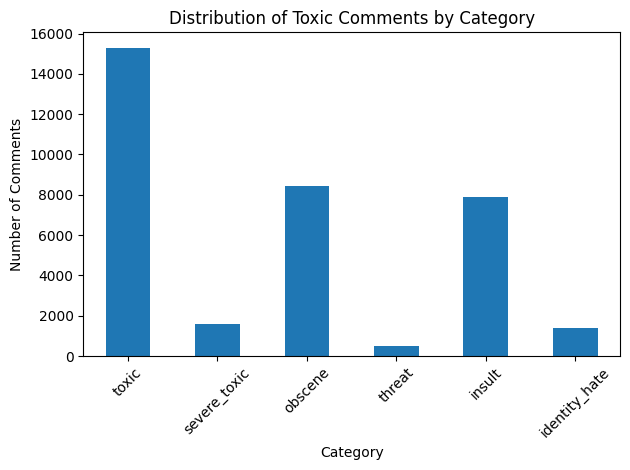

In [57]:
# Calculate the sum of each toxicity type
toxicity_counts = data.drop(["id", "comment_text"], axis=1).sum()

# Create bar plot
toxicity_counts.plot(kind='bar')
plt.title('Distribution of Toxic Comments by Category')
plt.xlabel('Category')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

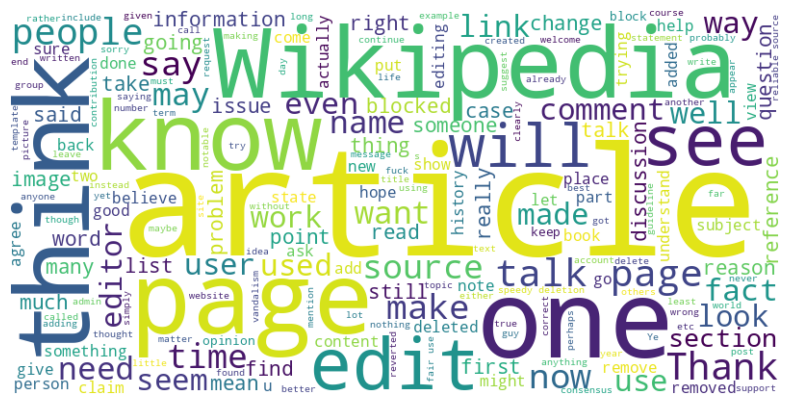

In [58]:
from wordcloud import WordCloud

# Combine all comments into a single string
text = ' '.join(data['comment_text'])

# Create and generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt

map data to labels

In [59]:
data=data.drop("id", axis=1)

In [60]:

data['label'] = data.drop(['comment_text'], axis=1).sum(axis=1)
data['label'] = data['label'].apply(lambda x: "toxic" if x >= 1 else "safe")
data.sample(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
26649,If you actually looked at the end of the artic...,0,0,0,0,0,0,safe
75713,Get of your high horse \n\nYeh you don't like ...,1,0,1,0,1,0,toxic
91491,vandal italy\nPLEASE block user 207.165.194.19...,0,0,0,0,0,0,safe
77679,"""\nAlthough I myself used it in referring to m...",0,0,0,0,0,0,safe
27864,{{|unblock|Its my friend which edited that and...,0,0,0,0,0,0,safe


In [61]:
# !wget https://raw.githubusercontent.com/InvalcreInc/parental-control-classification/refs/heads/main/modules/preprocess_text.py

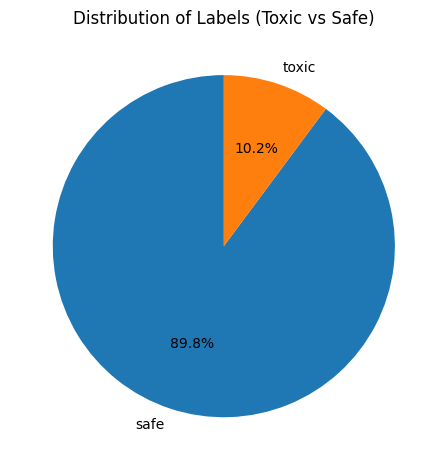

In [62]:
# Labels distribution
label_counts = data['label'].value_counts()
# plt.figure(figsize=(6, 4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels (Toxic vs Safe)')
plt.tight_layout()
plt.show()


In [63]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


def preprocess_text(text: str) -> str:
    '''
    Preprocesses the given text by converting it to lowercase, removing special characters, removing extra whitespaces, and removing stopwords.
    '''
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'[^\w\s!?.,;]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split()
                     if word not in stop_words])
    return text


if __name__ == "__main__":
    text = "Hello, how are you? This is a sample text."
    print(preprocess_text(text))

hello, you? sample text.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:

data['comment_text'] = data['comment_text'].apply(preprocess_text)
data.sample(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
73000,cracked think james kass cracked phrozen crew;...,0,0,0,0,0,0,safe
136285,"interesting claim, sort witch hunt. particular...",0,0,0,0,0,0,safe
27698,"seems show first two are, third intentional, u...",0,0,0,0,0,0,safe
145856,person banned persistent vandalism probably so...,0,0,0,0,0,0,safe
65827,address blocked 48 hours used evasion existing...,0,0,0,0,0,0,safe


## Oversample toxic data
to address imbalance

In [79]:
toxic_data = data[data['label'] == 'toxic']
safe_data = data[data['label'] == 'safe']
oversampled_toxic = toxic_data.sample(n=len(safe_data)//2, replace=True)
balanced_data = pd.concat([safe_data,toxic_data, oversampled_toxic])

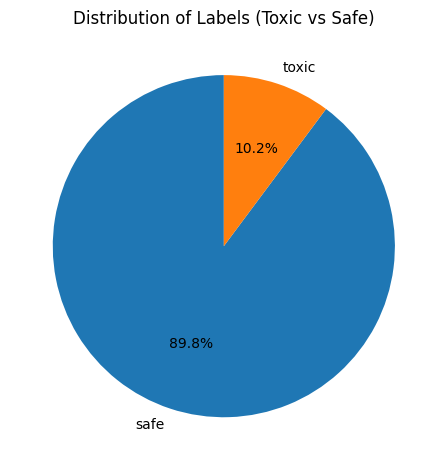

In [80]:
label_counts = balanced_data['label'].value_counts()
# plt.figure(figsize=(6, 4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels (Toxic vs Safe)')
plt.tight_layout()
plt.show()

format for fast text

In [67]:
def format_for_fasttext(row):
    return f'__label__{row["label"]} {row["comment_text"]}'

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# Split data (70% train, 20% val, 10% test)
train, temp = train_test_split(balanced_data, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.33, random_state=42)
train.shape, val.shape, test.shape

((161870, 8), (46480, 8), (22894, 8))

In [76]:
# Save train/val/test files
with open('train.txt', 'w', encoding='utf-8') as f:
    for _, row in train.iterrows():
        f.write(format_for_fasttext(row) + '\n')

with open('val.txt', 'w', encoding='utf-8') as f:
    for _, row in val.iterrows():
        f.write(format_for_fasttext(row) + '\n')

with open('test.txt', 'w', encoding='utf-8') as f:
    for _, row in test.iterrows():
        f.write(format_for_fasttext(row) + '\n')

In [45]:
import fasttext
# 4. Train fastText model
model = fasttext.train_supervised(
    input='train.txt',
    lr=0.1,
    epoch=25,
    wordNgrams=2,
    dim=100,
    loss='softmax',
    thread=4
)

Precision: 0.9604, Recall: 0.9604, Samples: 22894
              precision    recall  f1-score   support

        safe       0.94      1.00      0.97     14206
       toxic       1.00      0.90      0.95      8688

    accuracy                           0.96     22894
   macro avg       0.97      0.95      0.96     22894
weighted avg       0.96      0.96      0.96     22894



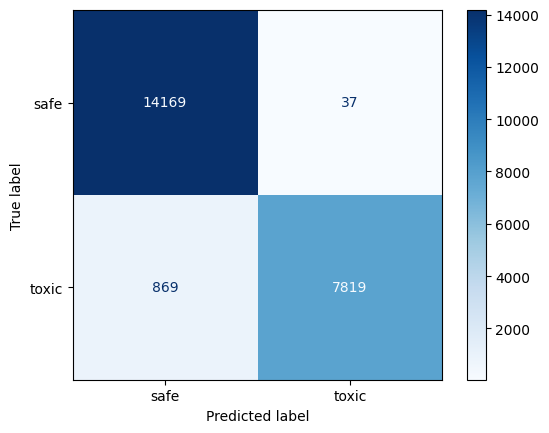

In [77]:
def evaluate_model(model, test_file):
    """Evaluate model on test set."""
    result = model.test(test_file)
    print(
        f"Precision: {result[1]:.4f}, Recall: {result[2]:.4f}, Samples: {result[0]}")

    # Detailed classification report
    test_texts = [line.strip().split(' ', 1)[1]
                  for line in open(test_file, 'r', encoding='utf-8')]
    test_labels = [line.strip().split(' ', 1)[0].replace('__label__', '')
                   for line in open(test_file, 'r', encoding='utf-8')]
    pred_labels=[]
    for text in test_texts:
      label,_ = model.predict(text)
      pred_labels.append(label[0].replace('__label__', ''))


    print(classification_report(test_labels, pred_labels))
    classes = ['safe', 'toxic']
    cm = confusion_matrix(test_labels, pred_labels, labels=classes)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

evaluate_model(model, 'test.txt')

Otpuna

In [47]:
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 0.01, 0.5)
    epoch = trial.suggest_int('epoch', 5, 25)
    wordNgrams = trial.suggest_int('wordNgrams', 1, 3)
    dim = trial.suggest_categorical('dim', [50, 100, 200])

    # Train FastText model
    model = fasttext.train_supervised(
        input='train.txt',
        lr=lr,
        epoch=epoch,
        wordNgrams=wordNgrams,
        dim=dim,
        loss='softmax',
        thread=4
    )

    # Evaluate the model on the validation set
    y_val_true = val['label'].apply(lambda x: x.replace('__label__', ''))
    y_val_pred = [model.predict(text)[0][0].replace('__label__', '') for text in val['comment_text']]

    accuracy = accuracy_score(y_val_true, y_val_pred)
    class_report = classification_report(y_val_true, y_val_pred)
    return accuracy, class_report

In [48]:
model.save_model("toxic_comments_model.bin")

In [49]:
# import optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# # Print the best hyperparameters
# print("Best hyperparameters: ", study.best_params)
# print("Best validation accuracy: ", study.best_value)